# Explore and Analysis MEG & EEG Data

In [1]:
import sys
import os
import os.path as op
import numpy as np
import pandas as pd
sys.path.append("../")
from mne_path import PathHandler
ph = PathHandler()
from glob import glob
import random

import mne

%matplotlib inline

# Loading data

* MNE-Python package was created to work with Neuromag's FIF file format and data structures are based around the FIF file format from Neuromag, 

* Nevertheless, the package consists of reader functions for other data formats and to interface with many publicly available datasets

The downloaded `MNE-sample-data` contains EEG, MEG and structural MRI data from an audiovisual experiment performed on volunteers

This sample dataset selected for this analysis is `sample_audvis_filt-0-40_raw.fif` which has previously been filtered and downsampled.  The original raw data is `sample_audvis_raw.fif`.

In [2]:
SAMPLE_DATA_DIR = ph.cddir(ph.SAMPLE_DIR)

# list of all fif files in sample data
FIF_FILES = sorted(glob(op.join(SAMPLE_DATA_DIR, "**/**/*.fif")))

print("Total FIF Files: ", len(FIF_FILES))
display(FIF_FILES[:5])

Changed to:  /Users/jonghang/mne_data/MNE-sample-data
Total FIF Files:  36


['/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/all-trans.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise-cov.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise_raw-eve.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif',
 '/Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif']

In [3]:
# sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = FIF_FILES[26]
raw = mne.io.read_raw_fif(sample_data_raw_file)

Opening raw data file /Users/jonghang/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


__Projection Items__

The Projection Items above are SSP projectors calculated to remove environmental noise from the MEG signals, plus a projector to mean-reference the EEG channels.  Details of these projections will be discussed in the future. 

In addition to the information displayed during loading, you can get a glimpse of the basic details of a Raw object by printing it; even more is available by printing its info attribute (a dictionary-like object that is preserved across Raw, Epochs, and Evoked objects). 

The info data structure keeps track of channel locations, applied filters, projectors, etc. Notice especially the chs entry, showing that MNE-Python detects different sensor types and handles each appropriately

# Power Spectral Density
__Built-In Plotting Methods__

Raw objects comes with several built-in plotting methods.  The following shows the use of `plot_psd` function to plot the power spectral density (PSD) for each sensor type with plot_psd, 

The function argument `fmax = 50` plot frequencies below 50 Hz because the selected data has been filtered with low-pass frequency of 40 Hz).

References:

* [Tutorial on Bandpower for EEG)](https://raphaelvallat.com/bandpower.html)
* [Case Studies in Neural Data Analysis](https://mark-kramer.github.io/Case-Studies-Python/03.html)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)


/Users/jonghang/opt/anaconda3/envs/torch311/lib/python3.11/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


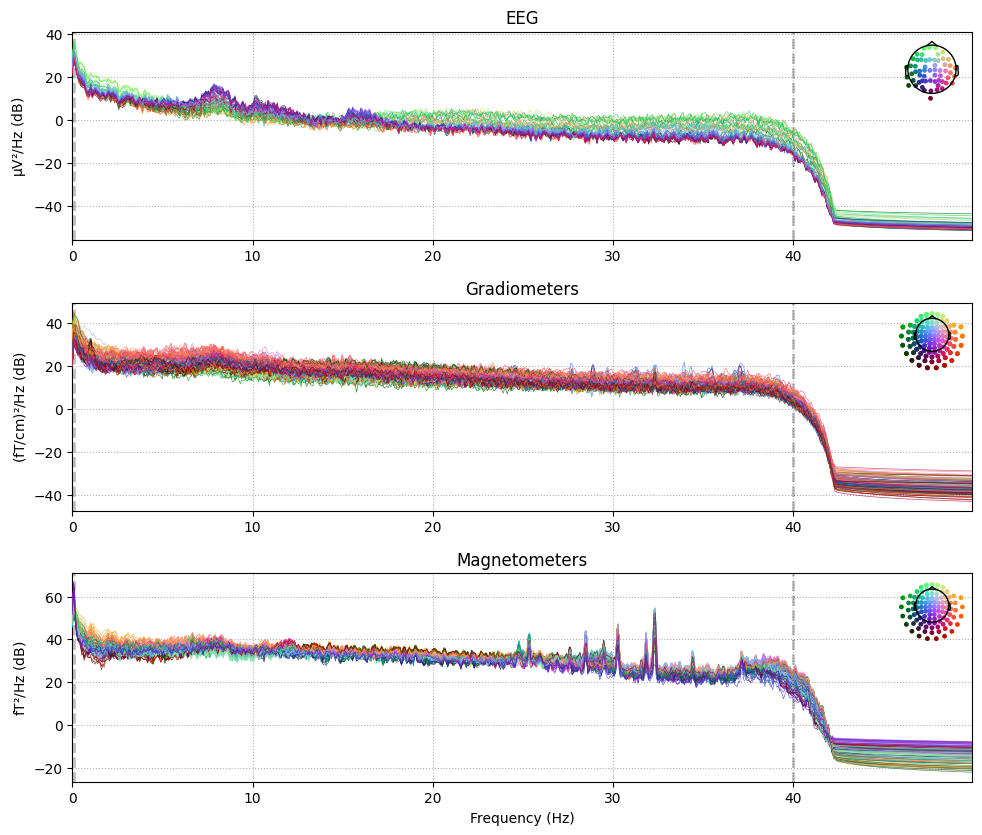

In [4]:
raw.plot_psd(fmax = 50)

Using matplotlib as 2D backend.


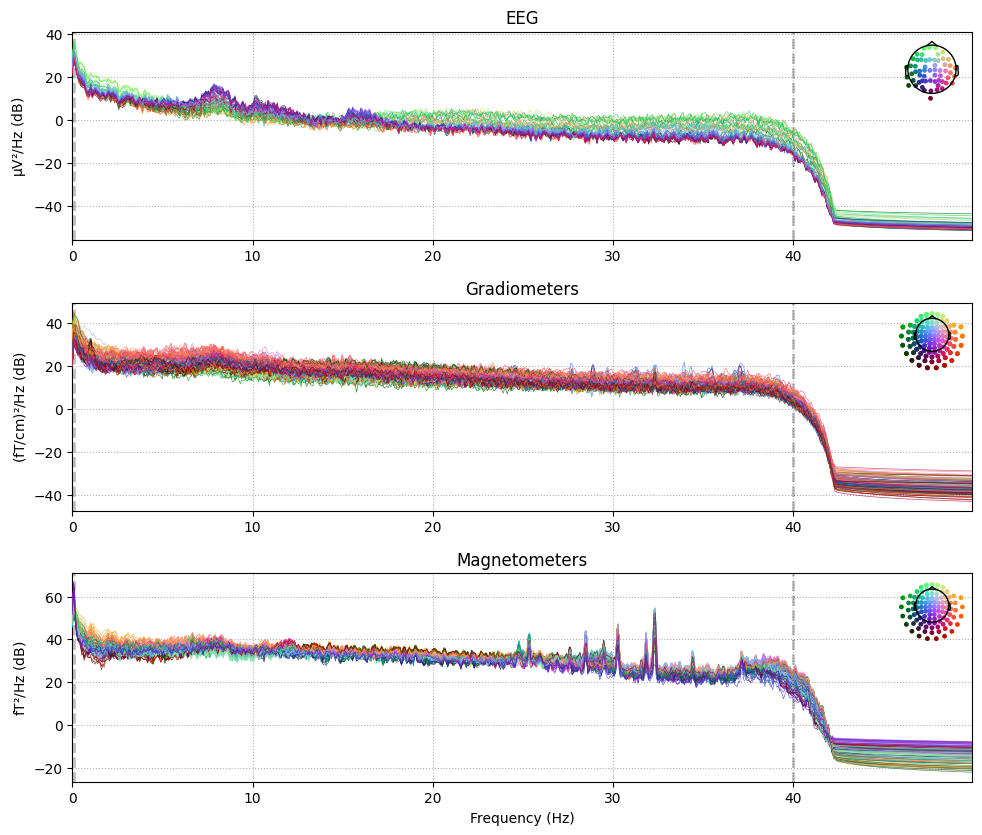

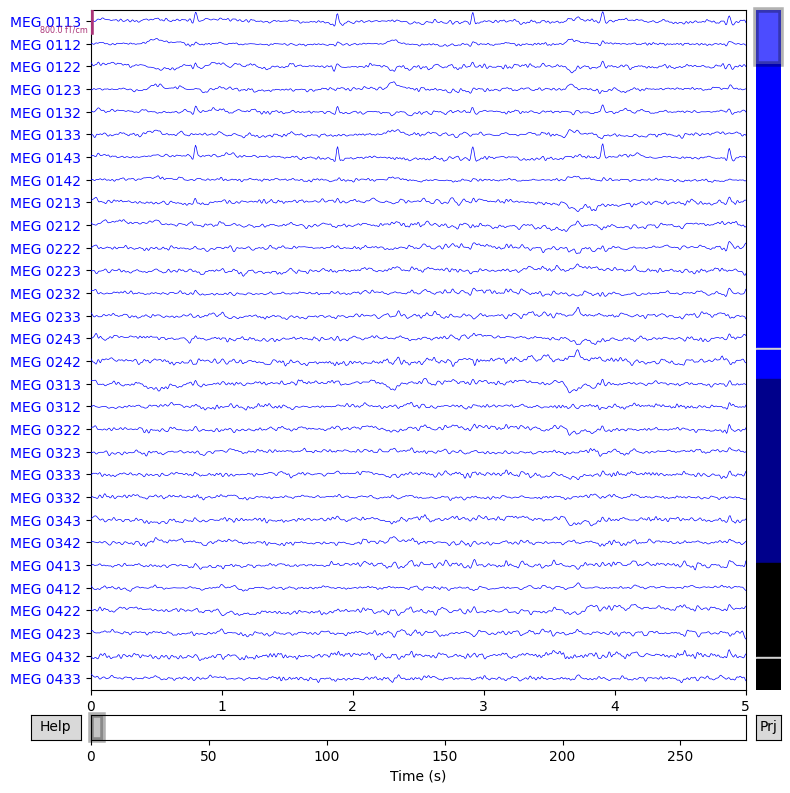

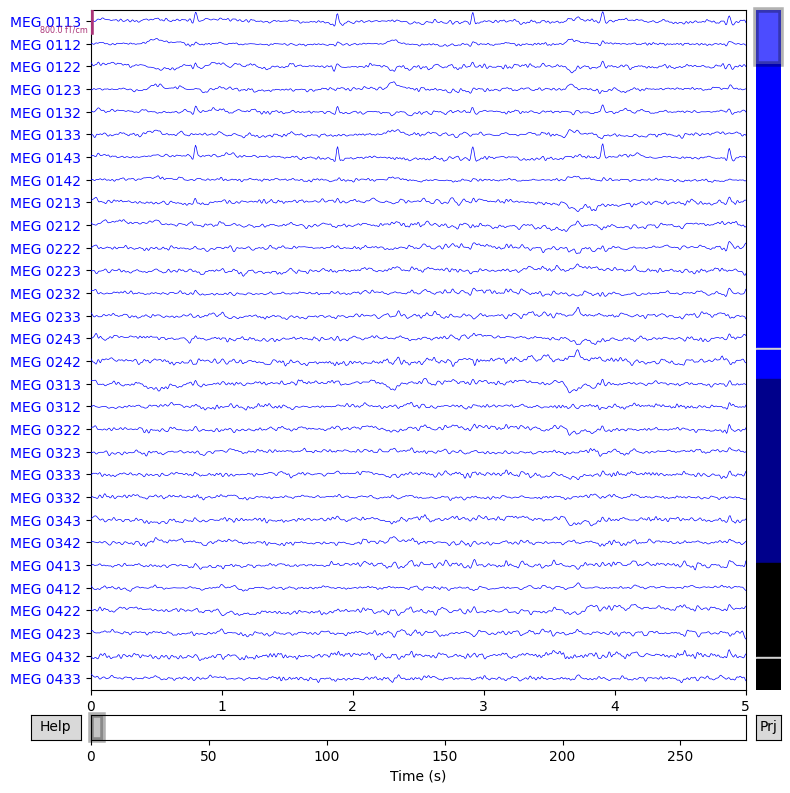

In [5]:
raw.plot(duration = 5, n_channels = 30)

# Independent Component Analysis (ICA)

The `mne.preprocessing` and `mne.filter` consists of a variety of tools for preprocessing such as maxwell filtering, signal-space projection, ICA, downsampling and much more.

ICA will be the focus of this analysis. It is used to determine which components best capture the artifacts 

ICA is also used to repair artifacts which will be discussed in the future

In [6]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components = 20, 
                            random_state = 97, 
                            max_iter = 800)
ica.fit(raw)

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 3.6s.


Method,fastica
Fit,27 iterations on raw data (41700 samples)
ICA components,20
Available PCA components,364
Channel types,"mag, grad, eeg"
ICA components marked for exclusion,—


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


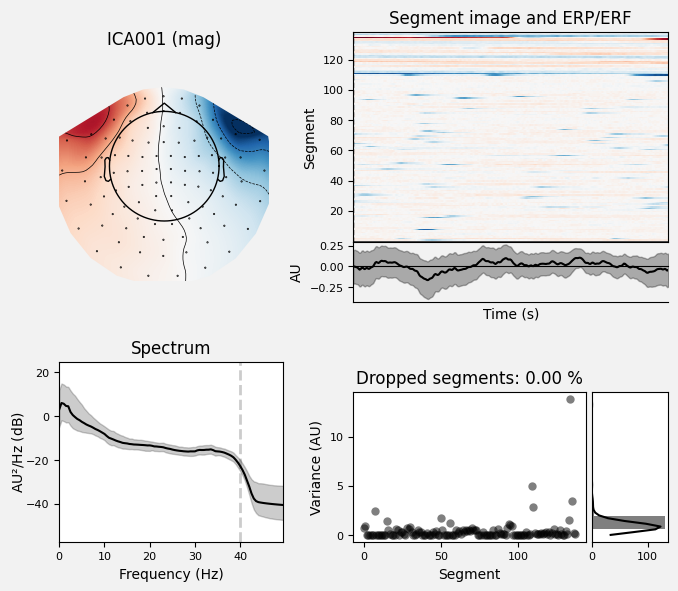

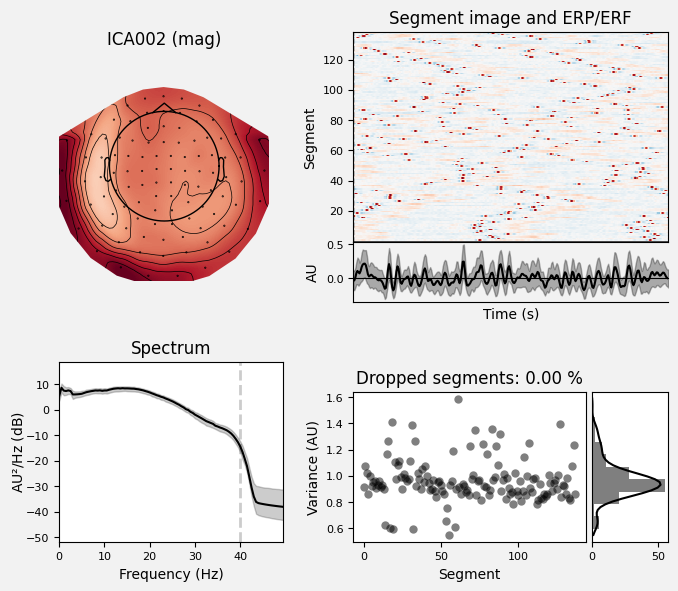

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [7]:
# select components to be excluded
ica.exclude = [1, 2] 
# examine properties of ICA
ica.plot_properties(raw, picks=ica.exclude)

After confirming which components to be removed, we pass them as the exclude parameter and then apply the ICA to the raw signal

The apply method requires the raw data to be loaded into memory (by default it’s only read from disk as-needed)

The `load_data` function is used to load the raw data and a copy of it is made for later side-by-side comparison before and after artifact removal:

In [8]:
orig_raw = raw.copy()
raw.load_data()
ica.apply(raw)

# show some frontal channels to clearly illustrate the artifact removal
chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
       'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
       'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
       'EEG 007', 'EEG 008']

chan_idxs = [raw.ch_names.index(ch) for ch in chs]

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 2 ICA components
    Projecting back using 364 PCA components


__Plot Original Raw Data__

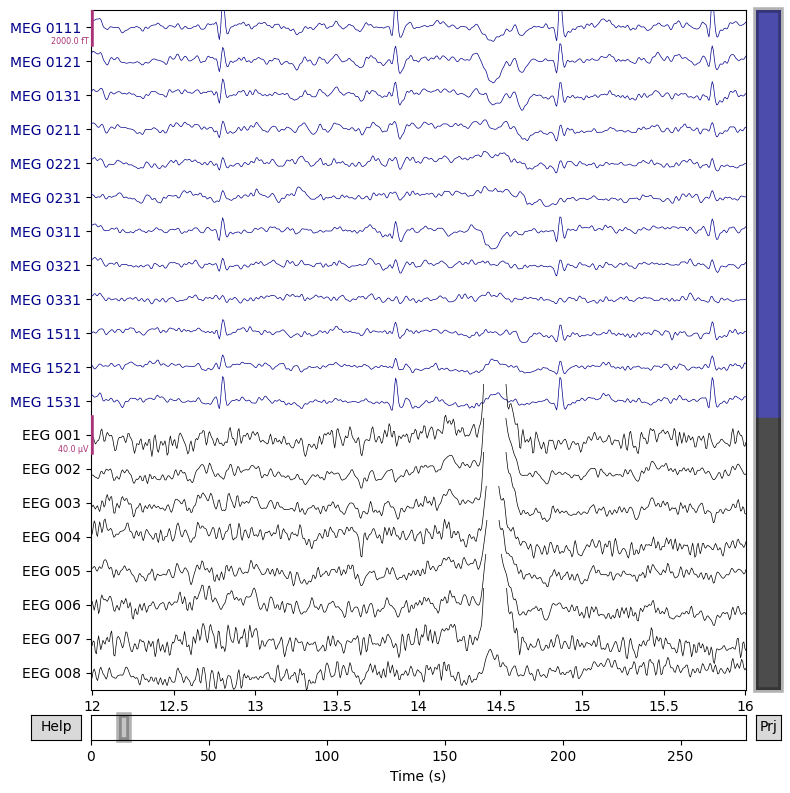

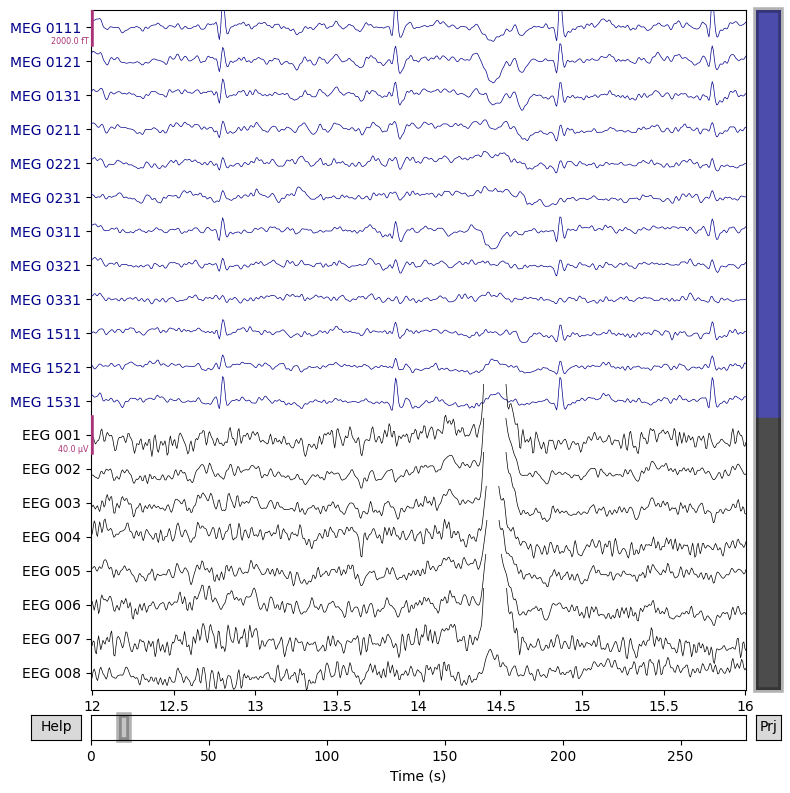

In [9]:
orig_raw.plot(order=chan_idxs, start=12, duration=4)

__Plot Raw Data After Artifact Removal__

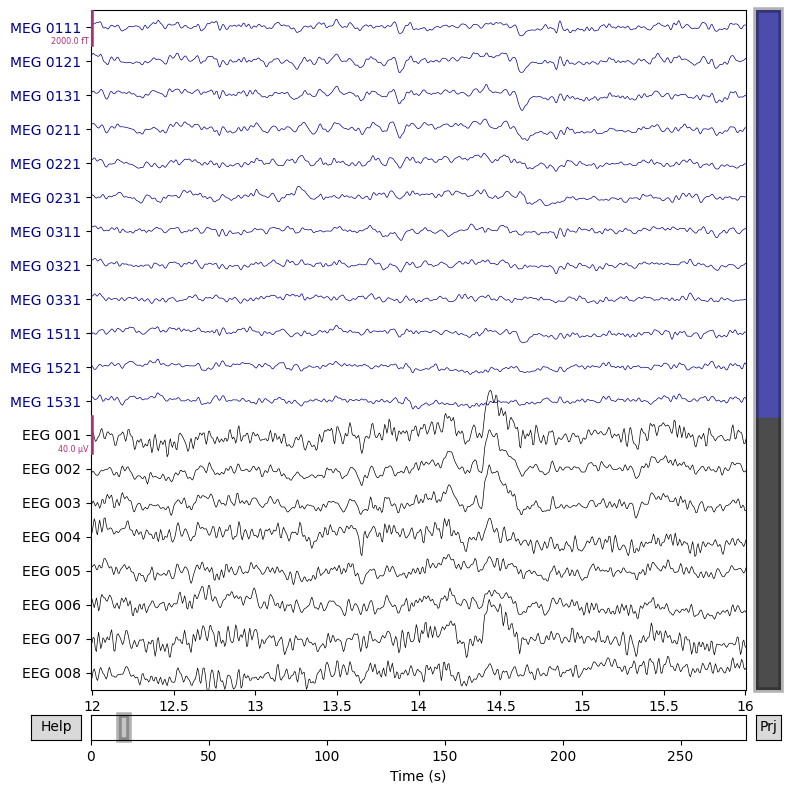

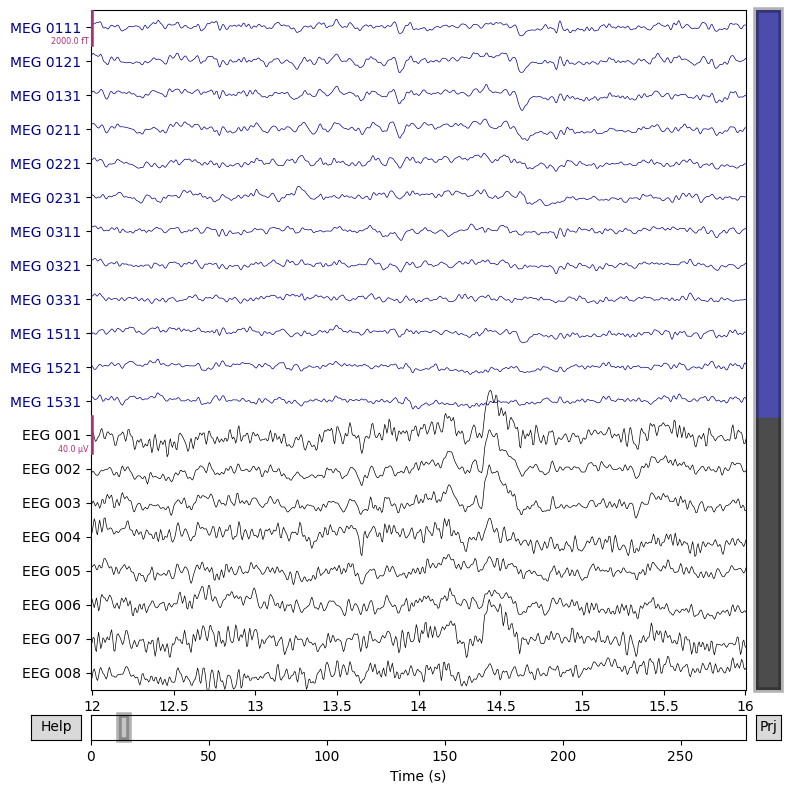

In [10]:
raw.plot(order=chan_idxs, start=12, duration=4)